# Downstream Analysis for Proteins Calculated from Mean of All Peptides



In [1]:
import os
import sys
import feather
import warnings

import numpy as np # Numerical computing
import pandas as pd # Data manipulation

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
from scipy import stats # Statistical library
from sklearn.decomposition import PCA # PCA from scikit-learn

sys.path.append('../')
from src import utils, plots, tests, enrich

warnings.filterwarnings('ignore')

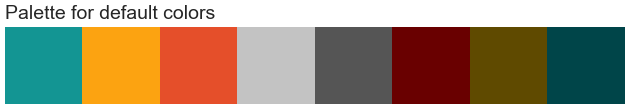

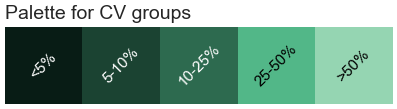

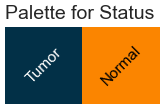

In [2]:
# Create a dictionary for a greyscale color palette with 9 colors
def_colors = [
    "#139593", "#fca311", "#e54f2a",
    "#c3c3c3", "#555555",
    "#690000", "#5f4a00", "#004549"
]

status_colors = {
    "Tumor": "#023047",
    "Normal": "#fb8500",
}
regulation_colors = {
    'Up': "#023047",
    'Down': '#fb8500'
}

cv_group_palettes = {
    "<5%":  "#081c15",  
    "5-10%":  "#1b4332",  
    "10-25%": "#2d6a4f",  
    "25-50%": "#52b788",  
    ">50%": "#95d5b2",  
}

# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

plots.color_palette(
    def_colors, 
    save=False
)

plots.color_palette(
    cv_group_palettes,
    name="CV groups",
    save=False
)

plots.color_palette(
    status_colors,
    name="Status",
    save=False
)

In [3]:
notebook_name = "5_meanAllAnalysis"
data_path = "./data/processed/"
input_path = f"./data/results/"
output_path = f"./data/results/{notebook_name}/"
figure_path = f"./figures/{notebook_name}/"

# Create the output folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Create figure folder structure, if needed
if save_to_folder:
    for i in figure_formats:
        cur_folder = figure_path + i + "/"
        if not os.path.exists(cur_folder):
            os.makedirs(cur_folder)

In [4]:
# Get the All Proteins Identified in the NBL dataset
background = list(set(feather.read_dataframe("./data/prepared/NBL_directDIA_May2024_protein.feather").index))

## Load the data

### Metadata

In [5]:
# Open the feather file
metadata = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_Metadata.feather")
utils.print_shape(metadata, "Metadata")
metadata.head()

Metadata data has 20 rows and 15 columns


,Filename,Date,Samples,Slot,UniqueNames,BCCHR ID,ID,Group,Differentiation,MKI,INPC,NMYC,Location,Location-Note,Info
9,[67] 20240313_GB_NBL-macro-74_Slot1-58_1_399.h...,20240313,NBL-macro-74,Slot1-58,NBL-macro-74_Slot1-58,74.0000,9.0000,Normal,None,None,None,None,AG,None,True
13,[68] 20240313_GB_NBL-macro-75_Slot1-59_1_400.h...,20240313,NBL-macro-75,Slot1-59,NBL-macro-75_Slot1-59,75.0000,13.0000,Normal,None,None,None,None,AG,None,True
15,[69] 20240313_GB_NBL-macro-76_Slot1-60_1_401.h...,20240313,NBL-macro-76,Slot1-60,NBL-macro-76_Slot1-60,76.0000,14.0000,Normal,None,None,None,None,AG,None,True
36,[71] 20240313_GB_NBL-macro-78_Slot1-62_1_403.h...,20240313,NBL-macro-78,Slot1-62,NBL-macro-78_Slot1-62,78.0000,33.0000,Normal,None,None,None,None,AG,None,True
43,[152] 20240322_GB_NBL-macro-80_Slot1-71_1_506....,20240322,NBL-macro-80,Slot1-71,NBL-macro-80_Slot1-71,80.0000,38.0000,Normal,None,None,None,None,AG,None,True


### Peptide Data

#### Peptide Info

In [6]:
# Peptide Information
peptide_info = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_InfoData.feather")
utils.print_shape(peptide_info, "Peptide Info")
peptide_info.head()

Peptide Info data has 117,290 rows and 11 columns


,Protein,Peptide,proteinDescription,geneName,startpos,endpos,seqLength,trace,Cov%,isCAP,PeptideID
0,A0A024RBG1,MKFKPNQTR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,1,10,181,0,23.7569,False,1
1,A0A024RBG1,TYDREGFK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,10,18,181,0,23.7569,False,2
2,A0A024RBG1,SEQEDEVLLVSSSR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,27,41,181,0,23.7569,False,3
3,A0A024RBG1,LLGIFEQNQDR,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,90,181,0,23.7569,False,4
4,A0A024RBG1,LLGIFEQNQDRK,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,79,91,181,1,23.7569,False,5


#### Peptide Quant

In [7]:
# Peptide Level Raw-Imputed Data
peptide_quan = feather.read_dataframe(f"{data_path}MatchedPatient_TumorNormal_PeptideLevel_TestData.feather")
peptide_quan = peptide_quan.rename(columns={"Sample": "UniqueNames"})
utils.print_shape(peptide_quan, "Raw Data")
peptide_quan.head()

Raw Data data has 2,345,800 rows and 13 columns


,Protein,Peptide,PeptideID,UniqueNames,Condition,Intensity,log10(Intensity),adjIntensity,isReal,isCompMiss,imputeW,TechVarW,Weight
0,A0A024RBG1,MKFKPNQTR,1,NBL-macro-74_Slot1-58,Normal,212.0579,2.3265,0.0685,False,False,0.0000,0.9965,0.0943
1,A0A024RBG1,TYDREGFK,2,NBL-macro-74_Slot1-58,Normal,209.3483,2.3209,-0.1467,False,False,0.0000,0.9879,0.0935
2,A0A024RBG1,SEQEDEVLLVSSSR,3,NBL-macro-74_Slot1-58,Normal,3387.1516,3.5298,0.4020,False,True,0.7500,0.9453,0.7682
3,A0A024RBG1,LLGIFEQNQDR,4,NBL-macro-74_Slot1-58,Normal,214.4361,2.3313,-0.0740,True,False,1.0000,0.9572,0.9957
4,A0A024RBG1,LLGIFEQNQDRK,5,NBL-macro-74_Slot1-58,Normal,248.7292,2.3957,0.1671,False,True,0.7500,0.9808,0.7717


### Calculation of Protein Quant

The method used to calculate the protein quant is the arithmetic mean of the all the peptides quant.

#### Protein Info

In [8]:
protein_info = peptide_info[["Protein", "proteinDescription",  "geneName", "seqLength", "Cov%", "isCAP"]].drop_duplicates()
utils.print_shape(protein_info, "Protein Info")
protein_info.head()

Protein Info data has 7,491 rows and 6 columns


,Protein,proteinDescription,geneName,seqLength,Cov%,isCAP
0,A0A024RBG1,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,181,23.7569,False
5,A0A075B6K5,Immunoglobulin lambda variable 3-9,IGLV3-9,115,42.6087,False
9,A0A075B6S2,Immunoglobulin kappa variable 2D-29,IGKV2D-29,120,45.8333,False
13,A0A0B4J1V6,Immunoglobulin heavy variable 3-73,IGHV3-73,119,33.6134,False
17,A0A0B4J2H0,Immunoglobulin heavy variable 1-69D,IGHV1-69D,117,60.6838,False


#### Protein Quant

In [9]:
# Pivot the table using the correct column names
protein_quan = peptide_quan.groupby([
    'Protein', 'UniqueNames'
])['Intensity'].mean().unstack()
utils.print_shape(protein_quan, "Protein level")
protein_quan.head()

Protein level data has 7,491 rows and 20 columns


UniqueNames,NBL-macro-107_Slot1-18,NBL-macro-108_Slot1-19,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-79_Slot1-63,NBL-macro-80_Slot1-71,NBL-macro-82_Slot1-65,NBL-macro-9_Slot1-43
Protein,,,,,,,,,,,,,,,,,,,,
A0A024RBG1,360.4043,347.3248,626.2066,488.8414,740.3944,246.7538,291.5645,253.5422,328.3613,318.1514,329.0270,252.3635,854.3446,609.4744,563.4888,761.5137,619.8238,814.1899,917.9955,258.6465
A0A075B6K5,4042.9113,1942.4476,1271.4841,2803.3581,1288.3396,4925.4266,2324.8066,3933.0546,888.9110,1153.7506,2211.2059,964.7650,1085.0819,1114.2548,951.4178,1251.6344,2833.5312,1471.4341,1142.7134,2051.0626
A0A075B6S2,2536.3751,2215.2858,916.0918,2058.2102,771.4161,2736.7686,1618.8665,1363.1169,2727.4664,1218.7876,3976.7360,959.6368,1161.7508,1026.4513,789.9719,832.0448,906.2607,2260.8569,786.5835,1749.9686
A0A0B4J1V6,891.2071,1145.0885,649.8671,741.4207,403.0247,2515.7173,386.2292,576.8181,466.5066,457.0469,389.7943,420.7407,835.1323,906.1199,815.6379,901.7947,982.5511,986.1144,753.7342,805.5404
A0A0B4J2H0,4447.0819,2042.7029,1482.6170,2393.8891,1015.5831,746.7304,1165.5142,1051.6659,1397.8123,768.6066,681.6794,714.0895,2211.2955,1575.9656,1780.6328,2237.8299,1677.0558,2332.1195,1251.1665,3001.9170


In [10]:
status_dict = {
    "Tumor": metadata[metadata["Group"] == "Tumor"]["UniqueNames"].values.tolist(),
    "Normal": metadata[metadata["Group"] == "Normal"]["UniqueNames"].values.tolist(),
}
sample_colors = {
    metadata["UniqueNames"].values[i]: status_colors[metadata["Group"].values[i]] for i in range(metadata.shape[0])
}

# Downstream Analysis

## Initial Look at the Data

In [12]:
# Normalize the data by Centering Medians

centered_data = protein_quan.copy()

centered_data = (
    (centered_data / centered_data.median()) * 
    (2**(int(np.log2(centered_data.mean(axis=1).median()))))
)

# Save the Centered Data
centered_data.to_feather(f"{output_path}centered_protein_data.feather")

centered_data.describe()

UniqueNames,NBL-macro-107_Slot1-18,NBL-macro-108_Slot1-19,NBL-macro-109_Slot1-20,NBL-macro-117_Slot1-28,NBL-macro-118_Slot1-29,NBL-macro-122_Slot1-77,NBL-macro-13_Slot1-46,NBL-macro-14_Slot1-47,NBL-macro-23_Slot1-06,NBL-macro-33_Slot1-15,NBL-macro-38_Slot1-19,NBL-macro-61_Slot1-44,NBL-macro-74_Slot1-58,NBL-macro-75_Slot1-59,NBL-macro-76_Slot1-60,NBL-macro-78_Slot1-62,NBL-macro-79_Slot1-63,NBL-macro-80_Slot1-71,NBL-macro-82_Slot1-65,NBL-macro-9_Slot1-43
count,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000,7491.0000
mean,614.2239,507.8971,428.2105,630.7337,535.8371,676.1604,576.2528,602.5362,521.4450,465.0088,489.5672,435.1882,477.8428,397.6887,465.9035,467.9003,390.9856,505.1050,501.4003,590.2225
std,2027.6100,1439.9688,1029.0177,3076.7551,2026.7520,2873.1847,1942.9412,2093.6234,1485.1306,1025.3206,1113.3946,1085.8584,1666.0539,1057.4240,1492.1600,1390.7406,1089.0796,1834.8745,1906.6021,1833.1226
min,6.7850,6.8980,5.0274,6.1648,6.5423,4.6457,5.5643,5.7081,6.1611,5.6524,6.9554,5.7189,5.2257,3.7546,4.7826,4.4244,3.8419,2.5487,5.4621,5.8958
25%,172.9878,143.9727,186.3167,179.0951,141.6283,135.6916,168.9197,171.8163,174.5882,169.1876,165.9157,184.3671,147.6111,150.1744,146.4997,145.3422,154.3346,143.4383,144.2344,171.8970
50%,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000,256.0000
75%,488.4133,477.4800,411.6799,460.9379,495.2690,543.9841,471.5113,476.7705,450.9291,448.5654,453.6054,400.5285,449.3506,419.0643,450.6911,444.2163,403.6151,438.1104,464.8324,479.6831
max,94309.3304,78264.4989,52681.9062,205216.3300,144047.4335,151957.0691,88472.2493,71375.0652,54422.4891,41689.3038,50442.1439,37304.5110,107777.6323,74767.2161,95211.7135,88078.5191,76516.4971,71854.4821,122198.9730,58705.4841


### Normality Check with QQ-Plot

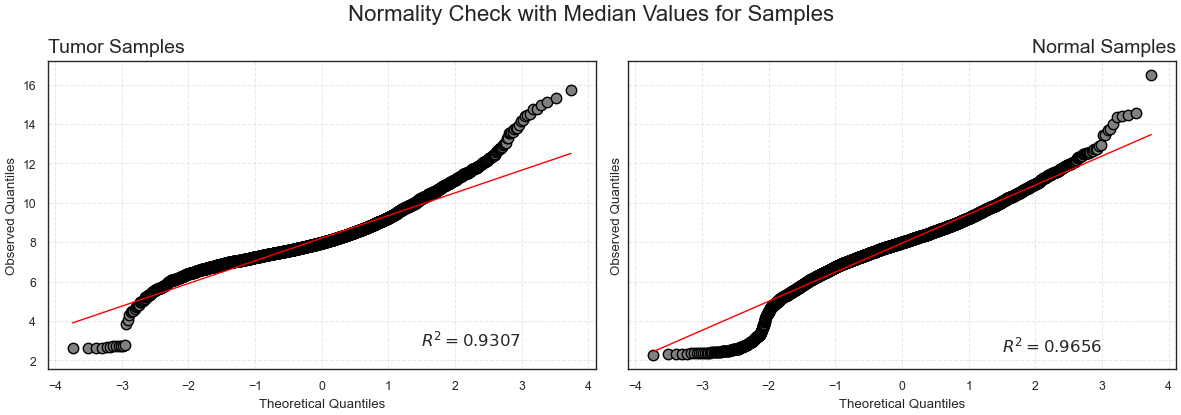

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2 , figsize=(12, 4), sharey=True)
## Tumor Samples
stats.probplot(np.log2(centered_data[status_dict["Tumor"]].median(axis=1)), dist='norm', plot=axes[0], rvalue=True)
# Update the point markers
axes[0].get_lines()[0].set_markerfacecolor('grey')
axes[0].get_lines()[0].set_markeredgecolor('black')
axes[0].get_lines()[0].set_markersize(7.5)
# Update the line
axes[0].get_lines()[1].set_linewidth(1)
axes[0].get_lines()[1].set_color('red')
# Update the text
axes[0].get_children()[2].set_fontsize(12)
# Remove the title
axes[0].set_title("")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Observed Quantiles")
axes[0].set_title("Tumor Samples", fontsize=14, loc="left")
axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
## Normal Samples
stats.probplot(np.log2(centered_data[status_dict["Normal"]].median(axis=1)), dist='norm', plot=axes[1], rvalue=True)
# Update the point markers
axes[1].get_lines()[0].set_markerfacecolor('grey')
axes[1].get_lines()[0].set_markeredgecolor('black')
axes[1].get_lines()[0].set_markersize(7.5)
# Update the line
axes[1].get_lines()[1].set_linewidth(1)
axes[1].get_lines()[1].set_color('red')
# Update the text
axes[1].get_children()[2].set_fontsize(12)
# Remove the title
axes[1].set_title("")
axes[1].set_xlabel("Theoretical Quantiles")
axes[1].set_ylabel("Observed Quantiles")
axes[1].set_title("Normal Samples", fontsize=14, loc="right")
axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey", zorder=1)
fig.tight_layout()
fig.suptitle("Normality Check with Median Values for Samples", fontsize=16, y=1.05)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="NormalityCheck_MedianValues_QQPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Boxplot

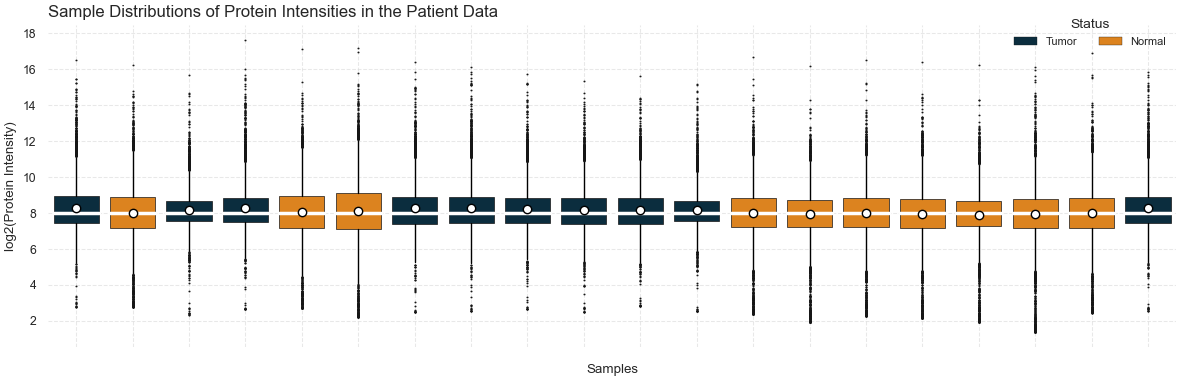

In [13]:
plot_data = np.log2(centered_data).melt(
    var_name="variable", 
    value_name="log2_intensity"
).dropna().set_index("variable")

plot_data = plot_data.merge(
    metadata[["UniqueNames", "Group", "Location"]].set_index("UniqueNames"),
    left_index=True,
    right_index=True,
    how="left"
).reset_index()

# Initialize the figure
fig, ax = plt.subplots(
    figsize=(12, 4)
)

# Create the boxplot
sns.boxplot(
    x="variable",
    y="log2_intensity",
    hue="Group",
    data=plot_data,
    ax=ax,
    dodge=False,
    palette=status_colors,
    # showfliers=False
    fliersize=0.5,
    linewidth=0.5,
    notch=False,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
    medianprops={"color": "white", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 1},
    capprops={"color": "black", "linewidth": 0},
    # Remove face and edge colors from the boxplot
    # boxprops={"facecolor": "white", "edgecolor": "black"},
)
# Set the x-axis labels

ax.set_xlabel("Samples")
ax.set_ylabel("log2(Protein Intensity)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment="right")
ax.set_xticklabels([])
ax.set_title("Sample Distributions of Protein Intensities in the Patient Data", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# place legend to upper right with 2 columns
ax.legend(loc="upper right", ncol=2, title="Status", title_fontsize=10, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.05))
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SamplesDistribution_Boxplot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Density Plots

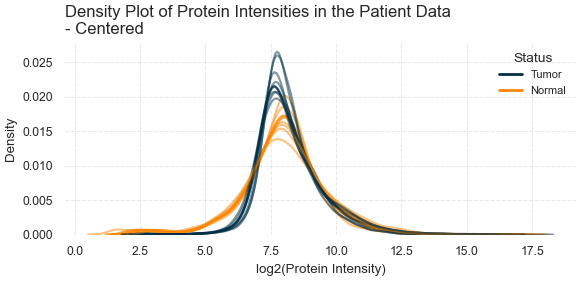

In [14]:
# Initialize the figure
fig, ax = plt.subplots(
    figsize=(6, 3)
)
sns.kdeplot(
    np.log2(centered_data),
    ax=ax,
    # fill=True,
    palette=sample_colors,
    linewidth=1.5,
    alpha=0.5,
    legend=False,
)

ax.set_xlabel("log2(Protein Intensity)")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Protein Intensities in the Patient Data \n- Centered", fontsize=12, loc="left")
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
# Assemble the legend from status colors dictionary tumor and normal two
ax.legend(
    handles=[
        plt.Line2D([0], [0], color=status_colors["Tumor"], lw=2),
        plt.Line2D([0], [0], color=status_colors["Normal"], lw=2),
    ],
    labels=["Tumor", "Normal"],
    title="Status",
    title_fontsize=10,
    fontsize=8,
    frameon=False,
    loc="upper right",
)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="SampleDistribution_DensityPlot",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### CV Plots

CV Data data has 14,982 rows and 4 columns


,mean,median,std
Status,,,
Normal,28.8237,22.1113,23.1447
Tumor,25.5710,20.4153,19.1056


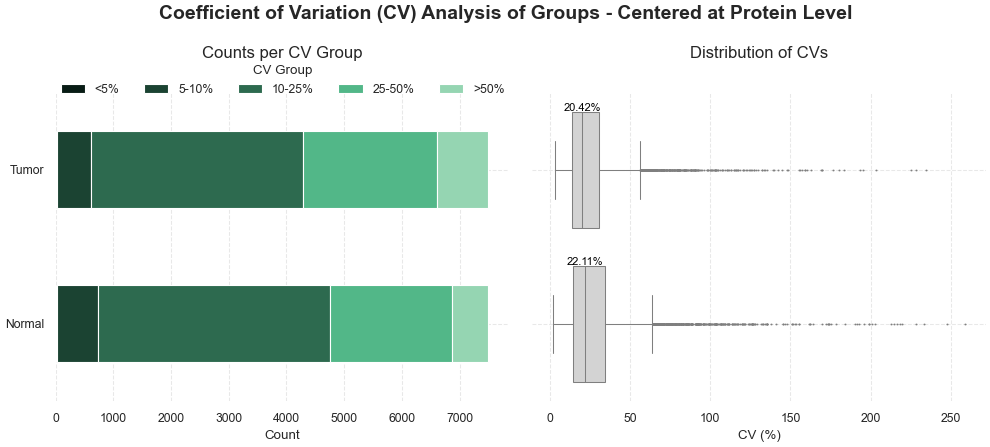

In [15]:
cv_data = pd.DataFrame(index = centered_data.index)
for k, v in status_dict.items():
    cv_data[k] = utils.cv_numpy(
        centered_data[v].values,
        axis=1,
        ignore_nan=True,
        format = "percent"
    )

medians = cv_data.median()

plot_data = cv_data.reset_index().melt(
    id_vars="Protein",
    var_name="Status",
    value_name="CV"
)

plot_data["CVGroup"] = pd.cut(
    plot_data["CV"],
    bins=[0, 5, 10, 25, 50, 100],
    labels=["<5%", "5-10%", "10-25%", "25-50%", ">50%"],
    right=False
).fillna(">50%")


utils.print_shape(plot_data, "CV Data")

# Create a CV figure with 2 subplots (1 x 2)
# 1: CVGroup Stacked Barplot
# 2: CV Distribution as violin
# Both horizontal
fig, axs = plt.subplots(
    1, 2, 
    figsize=(12, 4), 
    sharey=True,
    gridspec_kw={
        "width_ratios": [1, 1],
        "wspace": 0.05
    }
)

# CV Group Stacked Barplot
cv_counts = plot_data.groupby(["Status", "CVGroup"]).size().unstack().fillna(0)
cv_counts.plot(
    ax=axs[0],
    kind="barh",
    stacked=True,
    color=cv_group_palettes,
)

axs[0].set_xlabel("Count")
axs[0].set_ylabel("")
axs[0].set_title("Counts per CV Group", pad=25, fontsize=12)
# Put the legend on top with 5 columns
axs[0].legend(title="CV Group", frameon=False, bbox_to_anchor=(0.5, 1.125), ncol=5, loc="upper center")
axs[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# CV Distribution as boxplot
sns.boxplot(
    data=plot_data,
    x="CV",
    y="Status",
    ax=axs[1],
    color="lightgrey",
    linewidth=0.75,
    width=0.75,
    # outlier size
    fliersize=0.5
)

axs[1].set_xlabel("CV (%)")
axs[1].set_ylabel("")
axs[1].set_title("Distribution of CVs", pad=25, fontsize=12)
axs[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Annotate the median CVs on the boxplot
for i, v in enumerate(medians):
    axs[1].text(
        v, i-0.4, f"{v:.2f}%",
        va="center",
        ha="center",
        color="black",
        fontsize=8
    )

sns.despine(left=True, bottom=True)
plt.tight_layout()
fig.suptitle("Coefficient of Variation (CV) Analysis of Groups - Centered at Protein Level", fontsize=14, fontweight="bold", y=1.10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCVAnalysis",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

plot_data.groupby("Status")["CV"].agg(["mean", "median", "std"])

## Correlation Analysis

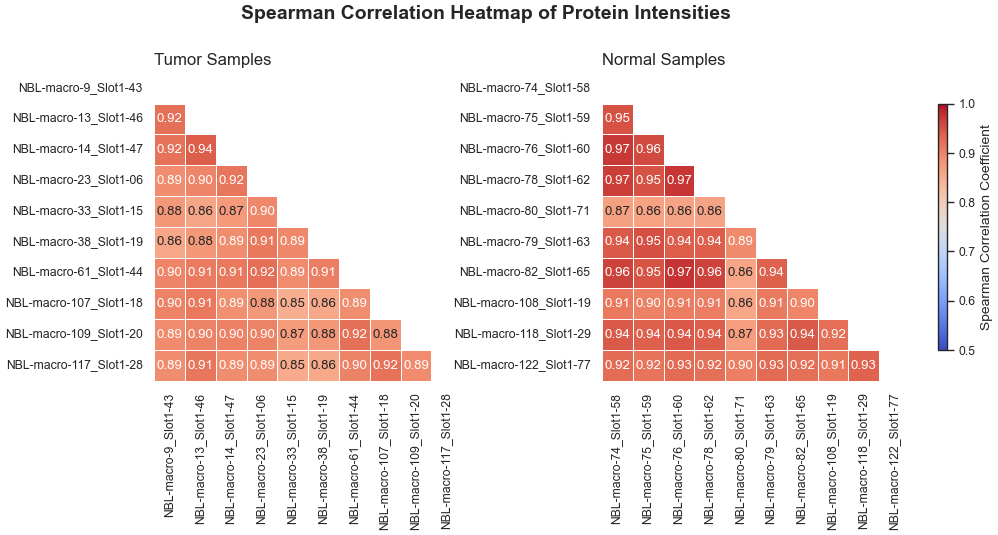

In [16]:
corrMethod = "spearman"
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 4),
    # sharey=True, sharex=True,
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.05}
)

## Tumor Samples
plot_data = centered_data[status_dict["Tumor"]].corr(method=corrMethod)

# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[0],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[0].set_title("Tumor Samples", fontsize=12, loc="left")
axes[0].set_ylabel("")
axes[0].set_xlabel("")
# axes[0].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

## Normal Samples
plot_data = centered_data[status_dict["Normal"]].corr(method=corrMethod)
# mask the upper triangle
mask = np.triu(np.ones_like(plot_data, dtype=bool))
sns.heatmap(
    plot_data,
    ax=axes[1],
    cmap="coolwarm",
    vmin=0.5,
    vmax=1,
    annot=True,
    fmt=".2f",
    mask=mask,
    cbar=False,
    square=True,
    linewidths=0.5,
    # linecolor="lightgrey",
)
axes[1].set_title("Normal Samples", fontsize=12, loc="left")
axes[1].set_ylabel("")
axes[1].set_xlabel("")
# axes[1].grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Add a title
fig.suptitle(f"{corrMethod.capitalize()} Correlation Heatmap of Protein Intensities", fontsize=14, fontweight="bold", y=1.05)
# plt.tight_layout()

## Add colorbar to the figure
cbar = axes[1].figure.colorbar(
    axes[1].collections[0], ax=axes, orientation="vertical", pad=0.01,
    fraction=0.05, aspect=30, shrink=0.8, anchor=(0.5, 0.5)
)
cbar.set_label(f"{corrMethod.capitalize()} Correlation Coefficient", fontsize=10)

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="ProteinCorrelationHeatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Unsupservised Look

### PCA

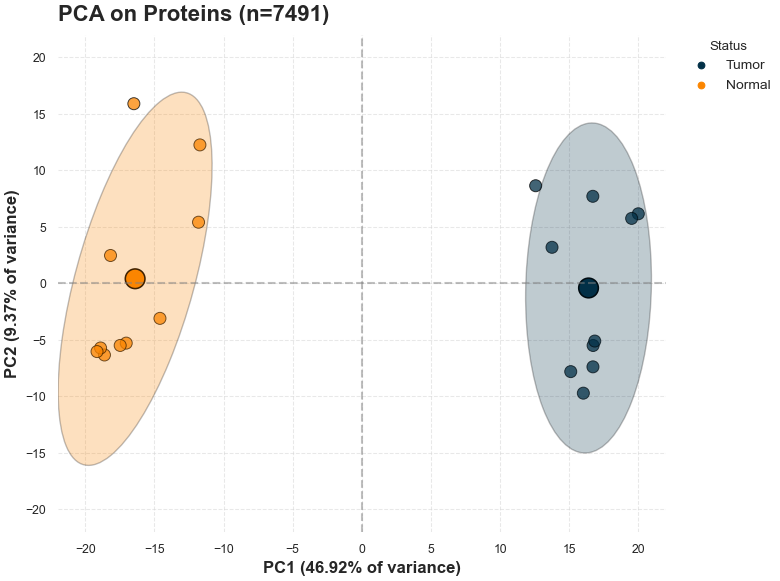

In [17]:
from sklearn.decomposition import PCA
# PCA
# Perform PCA on the centered data
scaler = "minmax"
# Drop any missing values
complete_data = centered_data.dropna()
# Scale the data
scaled_data = utils.scale_the_data(
    complete_data,
    method=scaler,
    axis=1,
    is_log=False
)

# Run the PCA
pca = PCA()
pca_res = pca.fit_transform(scaled_data.T)
pca_exp_var = pca.explained_variance_ratio_

# Set Variables
C1 = 0
C2 = 1
hue_group = "Group"  
style_group = "Differentiation"

# Create variables to be used
comp_locs = [C1, C2]
comp_names = [f'PC{c+1}' for c in comp_locs]

# Set the x and y label names
xlabel = f'{comp_names[0]} ({pca_exp_var[comp_locs[0]]:.2%} of variance)'
ylabel = f'{comp_names[1]} ({pca_exp_var[comp_locs[1]]:.2%} of variance)'
# Build the PCA Plot Data
plot_data = pd.DataFrame(pca_res[:,comp_locs], columns=comp_names)    
plot_data['UniqueNames'] = complete_data.columns
plot_data = plot_data.merge(
    metadata[['UniqueNames', 'Group', 'Location', 'Differentiation']],
    on='UniqueNames',
    how='left'
)

# Find Centroids for each Group-Sex combination calculated with PC1 and PC2 
centroid_data = plot_data.groupby([hue_group])[comp_names].mean()
centroid_data.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(8, 6))

# Centroids
sns.scatterplot(
    data=centroid_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=200,
    edgecolor='k',
    legend=False,
    alpha=1,
)

# Technical Replicates
sns.scatterplot(
    data=plot_data,
    x=comp_names[0],
    y=comp_names[1],
    hue=hue_group,
    # style=style_group,
    palette=status_colors,
    # markers=["o", "s"],
    s=75,
    edgecolor='k',
    alpha=0.75,
)

# Setup the X and Y axis limits
# Found the max and min values of the data
minVal = plot_data.iloc[:, :2].min().min()
maxVal = plot_data.iloc[:, :2].max().max()
limit = max(abs(minVal), abs(maxVal))
offset = 0.1 * limit
limit += offset
# Set the limits
ax.set_xlim(-limit, limit)
ax.set_ylim(-limit, limit)

## Setup the title and axis labels
# Set the title
ax.set_title(f"PCA on Proteins (n={complete_data.shape[0]})", fontsize=16, fontweight="bold", pad=10, loc="left")
# Set the x-axis label
ax.set_xlabel(xlabel, fontsize=12, fontweight="bold")
# Set the y-axis label
ax.set_ylabel(ylabel, fontsize=12, fontweight="bold")
## Add 0 lines
# Add vertical line
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
# Add horizontal line
ax.axhline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5)
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")

# Plot the confidence ellipses
# for hue, col in color_palettes[hue_group].items():
for hue, col in status_colors.items():
    x = plot_data.loc[(plot_data[hue_group]==hue), comp_names[0]].values
    y = plot_data.loc[(plot_data[hue_group]==hue), comp_names[1]].values
    if x.size > 1:
        plots.confidence_ellipse(x, y, plt.gca(), n_std=2, edgecolor='k', linewidth=1, alpha=0.25, facecolor=col)

ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=10, frameon=False, title="Status")
sns.despine(left=True, bottom=True)
plt.tight_layout()
# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_PCA",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

### Heatmap with Hierarchical Clustering

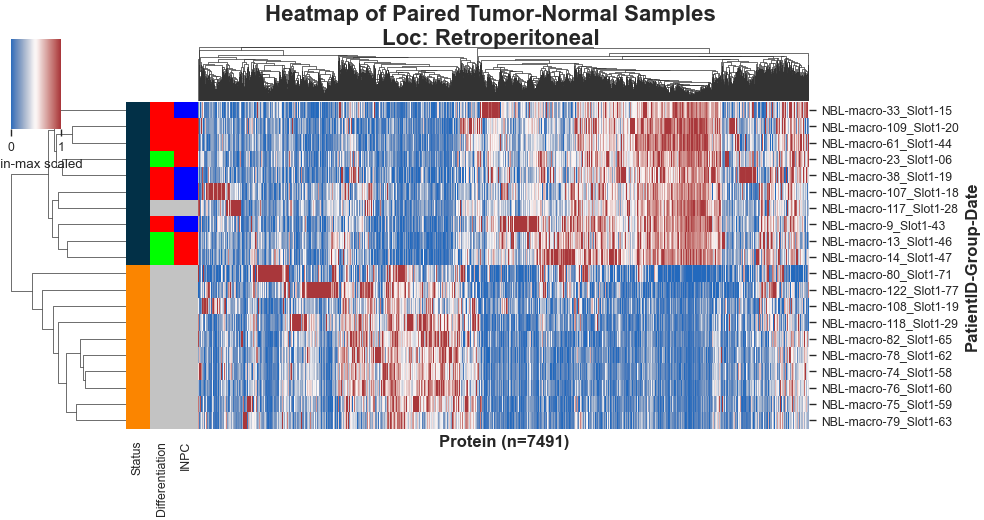

In [18]:
x_colors = pd.DataFrame(
    {
        "Status": metadata["Group"].map(status_colors),
        "Differentiation": metadata["Differentiation"].fillna("NA").map({
            "PD": "#ff0000",
            "UD": "#0000ff",
            "Diff": "#00ff00",
            "NA": "#c3c3c3"
        }),
        "INPC": metadata["INPC"].fillna("NA").map({
            "FH": "#ff0000",
            "UH": "#0000ff",
            "NA": "#c3c3c3"
        }),
    }
).set_index(metadata["UniqueNames"])

g = sns.clustermap(
    scaled_data.T,
    cmap="vlag",
    vmin=0,
    vmax=1,
    figsize=(10, 5),
    # method="ward",
    # metric="euclidean",
    row_cluster=True,
    col_cluster=True,
    xticklabels=False,
    # yticklabels=False,
    cbar_kws={
        "label": "min-max scaled",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.15,
        "aspect": 10,
    },
    rasterized=True,
    row_colors=x_colors,
    dendrogram_ratio=(0.15, 0.15),  
)

# Set the title
g.figure.suptitle(
    "Heatmap of Paired Tumor-Normal Samples\nLoc: Retroperitoneal",
    fontsize=16,
    fontweight="bold",
    y=1.05,
)

# Sex y axis-label as Protein(n={})
g.ax_heatmap.set_xlabel("Protein (n={})".format(scaled_data.shape[0]), fontsize=12, fontweight="bold")
g.ax_heatmap.set_ylabel("PatientID-Group-Date", fontsize=12, fontweight="bold")

# Save the figure
plots.save_figures(
    plt.gcf(),
    filename="Unsupervised_Heatmap",
    filepath=figure_path,
    fileformat=figure_formats,
    dpi=figure_dpi,
    transparent=transparet_bg
)

## Statistical Analysis

### Determine Equivalence Boundary (LFC) and T-Test LFC Boundary for QuEStVar

Total iterations: 10000

Power Analysis Results:
-----------------------

Input Parameters:
  - Target power: 0.90
  - Sample size (rep) per Group: 10
  - Mean Intra-sample CV: 25.00%
  - Number of Proteins: 1000
  - Significance threshold (p-value): 0.05
  - P-value correction method: fdr
  - Simulation Repeats: 1000

Simulation Results:
Symmetrical equivalence boundaries tested = [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
  - The minimum symmetrical equivalence boundary for target: 0.50


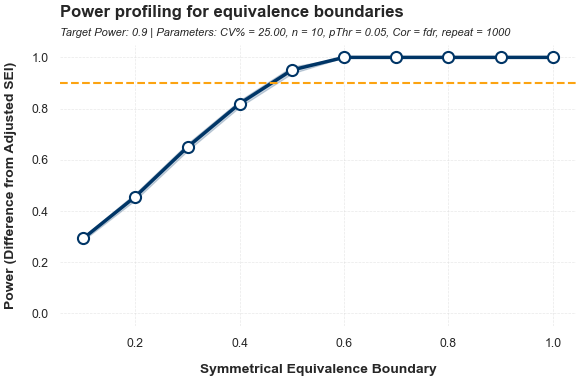

In [19]:
# Search for the optimal equivalence boundary
## Parameter to check
eqBoundary = None
eq_boundaries = np.linspace(0.1, 1.0, 10)

## Essential parameters
power = 0.90
nRep = 10
cvMean = 25
## Secondary parameters
nPrts = 1000
pThr = 0.05
corr = 'fdr'
dfThr = 1.0
cvThr = 10**5
nRepeats = 1000
nCores = None       # Use all available cores
# Simulated data parameters
int_mu = 18
int_sd = 1
int_log2 = True
cv_k = 2
cv_theta = 0.5

# Establish the Adjusted SEI
true_SEI = 1
adjs_SEI = 1 - cvMean/100

# Generate the CV distribution from the mean
cv_dist = tests.skewed_distribution(
    mu = cvMean,
    k = 2,
    theta = 0.5,
    size = nPrts
) / 100

cv_data = pd.DataFrame({
    "cvMean": cvMean,
    "cvDist": cv_dist
})

iterations = []
for eqThr in eq_boundaries:
    for i in range(nRepeats):
        iterations.append((
            cvMean, eqThr, nPrts, nRep, pThr, dfThr, cvThr, corr, i, int_mu, int_sd, int_log2, cv_k, cv_theta
        ))
print(f"Total iterations: {len(iterations)}")

# Run the simulation
results_df = tests.multiprocess_simulation(
    iterations = iterations,
    nCores = 28
)
# Calculate the power from SEI
results_df["calc_SEI"] = results_df["calc_SEI"].astype(float)
results_df["calc_power"] = results_df["calc_SEI"].apply(
    lambda x: tests.calculate_power(
        simulated_sei=x,
        target_sei=adjs_SEI
    )
)

# Print the results
tests.print_power_analysis_results(
    results_df = results_df,
    power = power,
    eqBoundaries = eq_boundaries,
    nRep = nRep,
    cvMean = cvMean,
    nPrts = nPrts,
    pThr = pThr,
    corr = corr,
    # dfThr = dfThr,
    # cvThr = cvThr,
    nRepeat = nRepeats
)
# Visualize the power profile
plots.single_variable_power_profile(
    results_df,
    x_axis_variable="eqThr",
    y_axis_variable = "calc_power",
    target_power = power,
    figtitle="Power profiling for equivalence boundaries",
    xlabel="Symmetrical Equivalence Boundary",
    save=True,
    filepath=figure_path,
    filename="powerProfile_eqThr_linePlot",
    fileformat=figure_formats,
)

### Running QuEStVar and Visualizing the Antlers

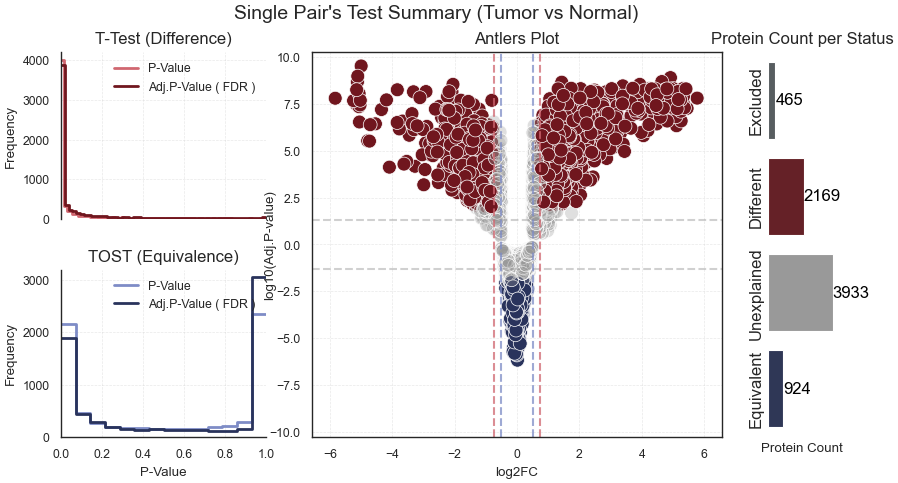

In [20]:
s1_arr = centered_data[status_dict["Tumor"]].values
s2_arr = centered_data[status_dict["Normal"]].values
res_df, info_df = tests.run_questvar(
    S1_arr = s1_arr,
    S2_arr = s2_arr,
    is_log2 = False,
    cv_thr=0.75,
    p_thr = 0.01, 
    df_thr = 0.75,
    eq_thr = 0.5,
    var_equal=True,
    is_paired=True,
)

res_df["Status"] = res_df["Status"].replace({
    0: "Unexplained",
    -1: "Different",
    1: "Equivalent"
})

res_df = res_df.join(centered_data.index.to_series().reset_index(drop=True))

plots.single_pair_summary(
    data = res_df,
    total_proteins = centered_data.shape[0],
    pair_names=["Tumor", "Normal"],
    dfThr = 0.75,
    eqThr = 0.5,
    save=True,
    filepath=figure_path,
    filename="QuEStVar_PairSummary",
    fileformat=figure_formats,
)

In [21]:
# Save the results
res_df.to_csv(f"{output_path}QuEStVar_PairSummary.csv", index=False)

## Enrichment Analysis

### Statistically Different Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 11603 proteins as custom background
  - running multi-query enrichment with 2 queries
      - using 1423 proteins for 'Tumor-Up' enrichment analysis
      - using 746 proteins for 'Tumor-Down' enrichment analysis
  - will use the 'gProf_pval0.001_Difference' as analysis name for id and save files

Background length: 11603
Tumor-Up: 1423
Tumor-Down: 746


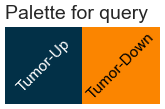

In [22]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001 
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
# background = None

enrichment_sets = {
    "Tumor-Up": list(set(res_df[
        (res_df["Status"] == "Different") & (res_df["log2FC"] > 0)
    ]["Protein"])),
    "Tumor-Down": list(set(res_df[
        (res_df["Status"] == "Different") & (res_df["log2FC"] < 0)
    ]["Protein"]))
}
query_palette = {
    "Tumor-Up": "#023047",
    "Tumor-Down": "#fb8500"
}
queries = ["Tumor-Up", "Tumor-Down"]

analysis_name = "gProf_pval{}_Difference".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

print()
print(f"Background length: {len(background)}")
# [k, len(v) for k, v in enrich.items()]
for k, v in enrichment_sets.items():
    print(f"{k}: {len(v)}")

plots.color_palette(
    query_palette,
    name = "query"
)

In [23]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Difference_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Difference_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

df_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {df_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    df_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 2
Number of terms per query:
   Tumor-Up -> 11819
   Tumor-Down -> 9727
Number of Unique enriched terms: 14618
Number of total terms saved: 21546
Enrichment result are prepared in 00h:00m:10s

After the p-value cutoff of 0.001 there are total of 289 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Tumor-Up -> 154
   Tumor-Down -> 135


In [24]:
df_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")
df_enrichment[df_enrichment['source'] == 'GO:CC']

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents
0,Tumor-Down,GO:CC,GO:0005739,mitochondrion,True,0.0000,0.0000,25.9572,15.0000,2.3251,0.1310,"['GO:0005737', 'GO:0043231']"
1,Tumor-Down,GO:CC,GO:0005737,cytoplasm,True,0.0000,0.0000,25.9572,15.0000,1.2500,0.0704,"['GO:0005622', 'GO:0110165']"
7,Tumor-Down,GO:CC,GO:0005759,mitochondrial matrix,True,0.0000,0.0000,19.8852,15.0000,3.3169,0.1869,"['GO:0005739', 'GO:0070013']"
21,Tumor-Up,GO:CC,GO:0043005,neuron projection,True,0.0000,0.0000,13.4428,13.4428,1.7920,0.2013,['GO:0120025']
27,Tumor-Up,GO:CC,GO:0045202,synapse,True,0.0000,0.0000,10.3004,10.3004,1.6247,0.1825,['GO:0030054']
...,...,...,...,...,...,...,...,...,...,...,...,...
268,Tumor-Down,GO:CC,GO:0031090,organelle membrane,True,0.0005,0.0005,3.2597,3.2597,1.2920,0.0728,"['GO:0016020', 'GO:0043227']"
285,Tumor-Up,GO:CC,GO:0051233,spindle midzone,True,0.0010,0.0010,3.0160,3.0160,3.4046,0.3824,"['GO:0005819', 'GO:0110165']"
286,Tumor-Down,GO:CC,GO:0005925,focal adhesion,True,0.0010,0.0010,3.0055,3.0055,1.8866,0.1063,['GO:0030055']
287,Tumor-Down,GO:CC,GO:0005782,peroxisomal matrix,True,0.0010,0.0010,3.0055,3.0055,4.4359,0.2500,"['GO:0005777', 'GO:0031907']"


### Statistically Equivalent Proteins

Enrichment analysis parameters:
  - match p-value threshold: 1
  - enrichment p-value threshold: 0.001
  - correction method: fdr
  - capping p-value at: 1e-15
  - using hsapiens as organism
  - getting results from ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP'] 
  - using 7491 proteins as custom background
      - using 924 proteins for 'Equivalent' enrichment analysis
  - will use the 'gProf_pval0.001_Equivalence' as analysis name for id and save files


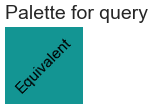

In [25]:
# Variables for the enrichment setup
m_pval = 1 
e_pval = 0.001 
correction = 'fdr' # fdr, bonferroni, g_SCS
pval_cap = 10**-15 
organism = "hsapiens"
sources = ['GO:BP', 'GO:MF', 'GO:CC', 'KEGG', 'REAC', 'WP']
background = protein_info["Protein"].tolist()
# background = None

enrichment_sets = {
    "Equivalent": list(set(
        res_df[res_df["Status"] == "Equivalent"]["Protein"]
    ))
}
query_palette = {
    "Equivalent": def_colors[0]
}
queries = ['Equivalent']

analysis_name = "gProf_pval{}_Equivalence".format(e_pval)

enrich.printParams(
    m_pval,
    e_pval,
    correction,
    pval_cap,
    organism,
    sources,
    background,
    enrichment_sets,
    analysis_name
)

plots.color_palette(
    query_palette,
    name = "query"
)

In [26]:
# Run and Save the Enrichment Analysis
enrich.run_gprofiler(
    query = enrichment_sets,
    background = background,
    organism = organism,
    user_threshold = m_pval,
    signf_threshold = e_pval,
    correction = correction,
    sources = sources,
    pval_cap = pval_cap,
    no_evidences = True,
    no_iea = False,
    ordered = False,
    simplify_cols=True,
    save_path = output_path,
    analysis_name = "gProf_Equivalence_FullList",
    verbose = True
)

print()

# Read the results
gp_res = pd.read_csv(
    os.path.join(
        output_path, 
        "gProf_Equivalence_FullList.csv"
    ),
    sep=","
)

# Create a subset of the results with the p-value cutoff
subset_gp_res = gp_res[
    gp_res["p_value"] < e_pval
]

# Save the subset results
subset_gp_res.to_csv(
    f"{output_path}{analysis_name}.csv",
    sep=",",
    index=False
)

eq_enrichment = pd.read_csv(f"{output_path}{analysis_name}.csv")

print(f"""After the p-value cutoff of {e_pval} there are total of {eq_enrichment.shape[0]} enriched terms.""")

utils.print_series(
    eq_enrichment["query"].value_counts(),
    header = f"Number of enriched terms per query with p-val cutoff {e_pval}:",
    tab = 2,
    elements_with_order = queries
)

Capping the p_value at 1e-15
Simplifying the columns.
P-value threshold: 1 
Correction method: fdr
Number of queries: 1
Number of terms per query:
   Equivalent -> 11046
Number of Unique enriched terms: 11046
Number of total terms saved: 11046
Enrichment result are prepared in 00h:00m:04s

After the p-value cutoff of 0.001 there are total of 67 enriched terms.
Number of enriched terms per query with p-val cutoff 0.001:
   Equivalent -> 67


## Enrichment Summary 

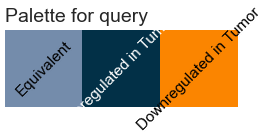

,query,source,native,name,significant,p_value,p_capped,-log10(p_value),-log10(p_capped),Enrichment,GeneRatio,parents
0,Downregulated in Tumor,GO:CC,GO:0005739,mitochondrion,True,0.0000,0.0000,25.9572,15.0000,2.3251,0.1310,"['GO:0005737', 'GO:0043231']"
1,Downregulated in Tumor,GO:CC,GO:0005737,cytoplasm,True,0.0000,0.0000,25.9572,15.0000,1.2500,0.0704,"['GO:0005622', 'GO:0110165']"
2,Downregulated in Tumor,REAC,REAC:R-HSA-1430728,Metabolism,True,0.0000,0.0000,22.8498,15.0000,2.1305,0.1201,['REAC:0000000']
3,Downregulated in Tumor,GO:BP,GO:0044281,small molecule metabolic process,True,0.0000,0.0000,21.1463,15.0000,2.2657,0.1277,['GO:0008152']
4,Upregulated in Tumor,GO:BP,GO:0007399,nervous system development,True,0.0000,0.0000,20.2403,15.0000,1.6784,0.1885,['GO:0048731']
...,...,...,...,...,...,...,...,...,...,...,...,...
62,Equivalent,GO:BP,GO:0008152,metabolic process,True,0.0009,0.0009,3.0557,3.0557,1.1018,0.1244,['GO:0008150']
63,Equivalent,GO:BP,GO:0007034,vacuolar transport,True,0.0009,0.0009,3.0524,3.0524,2.3310,0.2632,['GO:0046907']
64,Equivalent,GO:BP,GO:0051028,mRNA transport,True,0.0009,0.0009,3.0466,3.0466,2.4079,0.2718,['GO:0050658']
65,Equivalent,GO:CC,GO:0000145,exocyst,True,0.0009,0.0009,3.0366,3.0366,5.4509,0.6154,"['GO:0005938', 'GO:0099023']"


In [27]:
query_palette = {
    "Equivalent": "#748cab",
    "Upregulated in Tumor": "#023047",
    "Downregulated in Tumor": "#fb8500"
}
plots.color_palette(
    query_palette,
    name = "query"
)
enrichment_data = pd.concat([df_enrichment, eq_enrichment])
enrichment_data['query'] = enrichment_data['query'].replace({
    "Tumor-Up": "Upregulated in Tumor",
    "Tumor-Down": "Downregulated in Tumor",
    "Equivalent": "Equivalent"
})
enrichment_data

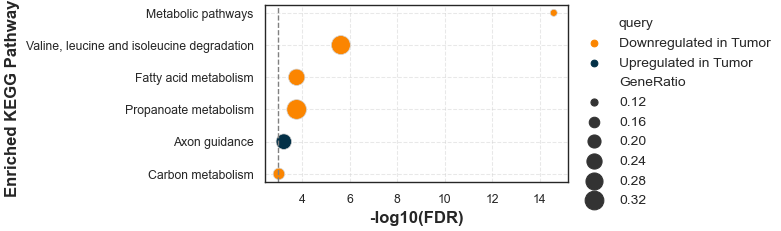

In [28]:
cur_source = "KEGG"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()

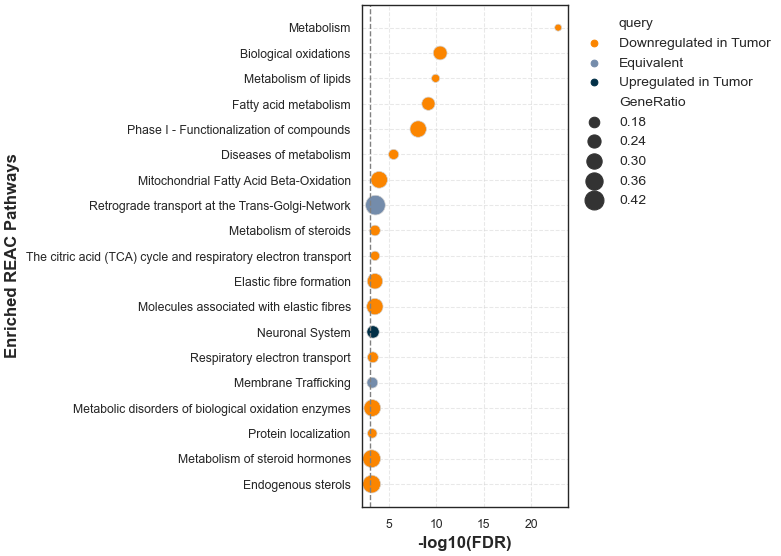

In [29]:
cur_source = "REAC"
plot_data = enrichment_data[
    (enrichment_data["source"] == cur_source) & 
    (enrichment_data["native"]!=f"{cur_source}:00000")
].sort_values('p_value').copy()
n_unique = plot_data["native"].nunique()

# Initialize the figure
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(8, 1 + n_unique * 0.25),
)

sns.scatterplot(
    ax=ax,
    data=plot_data,
    y="name",
    x="-log10(p_value)",
    hue="query",
    size="GeneRatio",
    edgecolor="lightgray",
    palette=query_palette,
    linewidth=.5,
    sizes=(25, 200),
    legend='brief',
)

# Add line at p-value cutoff
ax.axvline( -np.log10(e_pval), color="gray", linestyle="--", linewidth=1 )

# Add Styling to the plot
ax.set_xlabel("-log10(FDR)", fontsize=12, fontweight="bold")
ax.set_ylabel(f"Enriched {cur_source} Pathways", fontsize=12, fontweight="bold")
# Add grid
ax.grid("both", linestyle="--", linewidth=0.75, alpha=0.5, color="lightgrey")
ax.legend(
    frameon=False,
    fontsize=10,
    title_fontsize=14,
    loc="upper left",
    bbox_to_anchor=(1, 1),
    # title="Enrichment Query",
)
plt.tight_layout()